# Survival Analysis Home Work

Ноутбуки направить на почту simon.ilishaev@gmail.com. В теме письма - [FEFU_SBER]

## Dataset
We'll use the AIDS Clinical Trial dataset (`sksurv.datasets.load_aids`). This dataset contains information about AIDS patients in a clinical trial, with time-to-event data for progression to AIDS.

[DATASET DESCRIPTION](https://web.archive.org/web/20170517080800/http://www.umass.edu/statdata/statdata/data/actg320.txt)

In [ ]:
from sksurv.datasets import load_aids
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
import xgboost as xgb

from sksurv.util import Surv
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset
data_x, data_y = load_aids()
data = pd.DataFrame(data_x)
data['time'] = data_y['time']
data['event'] = data_y['censor']

In [ ]:
# Display the first few rows to understand the columns
display(data.head())

# Task 1: Kaplan-Meier Analysis

1.1 Overall Survival Curve

Plot the Kaplan-Meier survival curve for the entire population.

In [ ]:
# USE KaplanMeierFitter and kmf.plot_survival_function

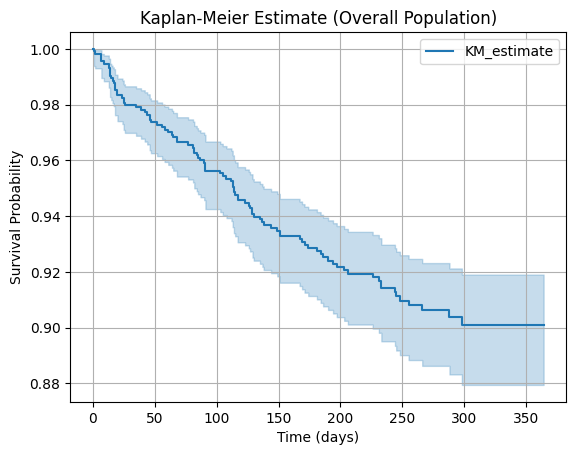

1.2 Stratified Analysis

Plot separate Kaplan-Meier curves for patients in different treatment groups (use 'tx' column where 0=control, 1=treatment). Perform a log-rank test to compare the survival distributions.

In [ ]:
# First ensure all columns have the correct data types
data['time'] = pd.to_numeric(data['time'])
data['event'] = data['event'].astype(bool)  # Convert to boolean if not already
data['tx'] = data['tx'].astype(int)  # Ensure treatment is integer

# Check for missing values
print("Missing values in time:", data['time'].isna().sum())
print("Missing values in event:", data['event'].isna().sum())
print("Missing values in tx:", data['tx'].isna().sum())

# Remove rows with missing values if any exist
data = data.dropna(subset=['time', 'event', 'tx'])

# Now plot the curves
# TODO

# Log-rank test
# USE logrank_test
#TODO

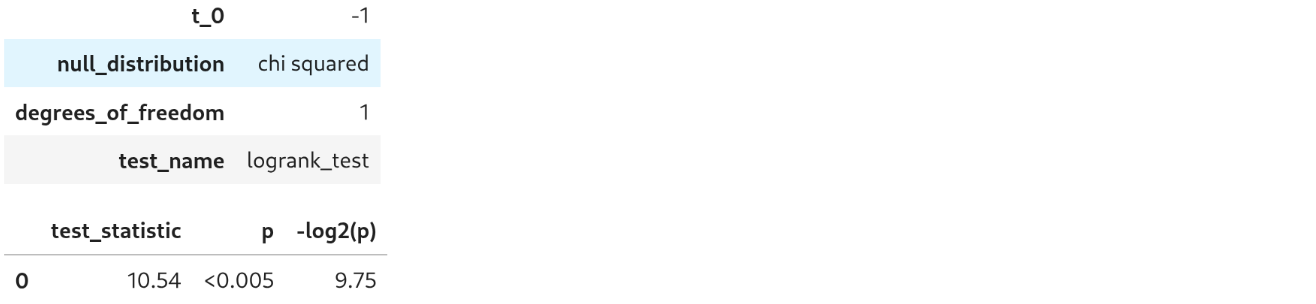

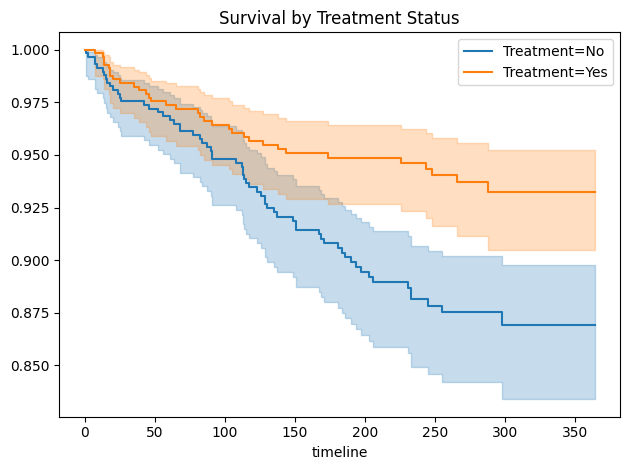

# Task 2: Cox Proportional Hazards Model

2.1 Fit Cox Model

Fit a Cox proportional hazards model using these covariates: ['age', 'cd4', 'karnof', 'priorzdv', 'tx']. Interpret the coefficients.

In [ ]:
# USE CoxPHFitter & cph.print_summary
# TODO

# Interpretation:
# - Positive coefficients increase hazard (worse survival)
# - Negative coefficients decrease hazard (better survival)
# - exp(coef) is the hazard ratio
# Example interpretation for 'cd4':
# For each unit increase in CD4 count, the hazard of progression decreases by X%

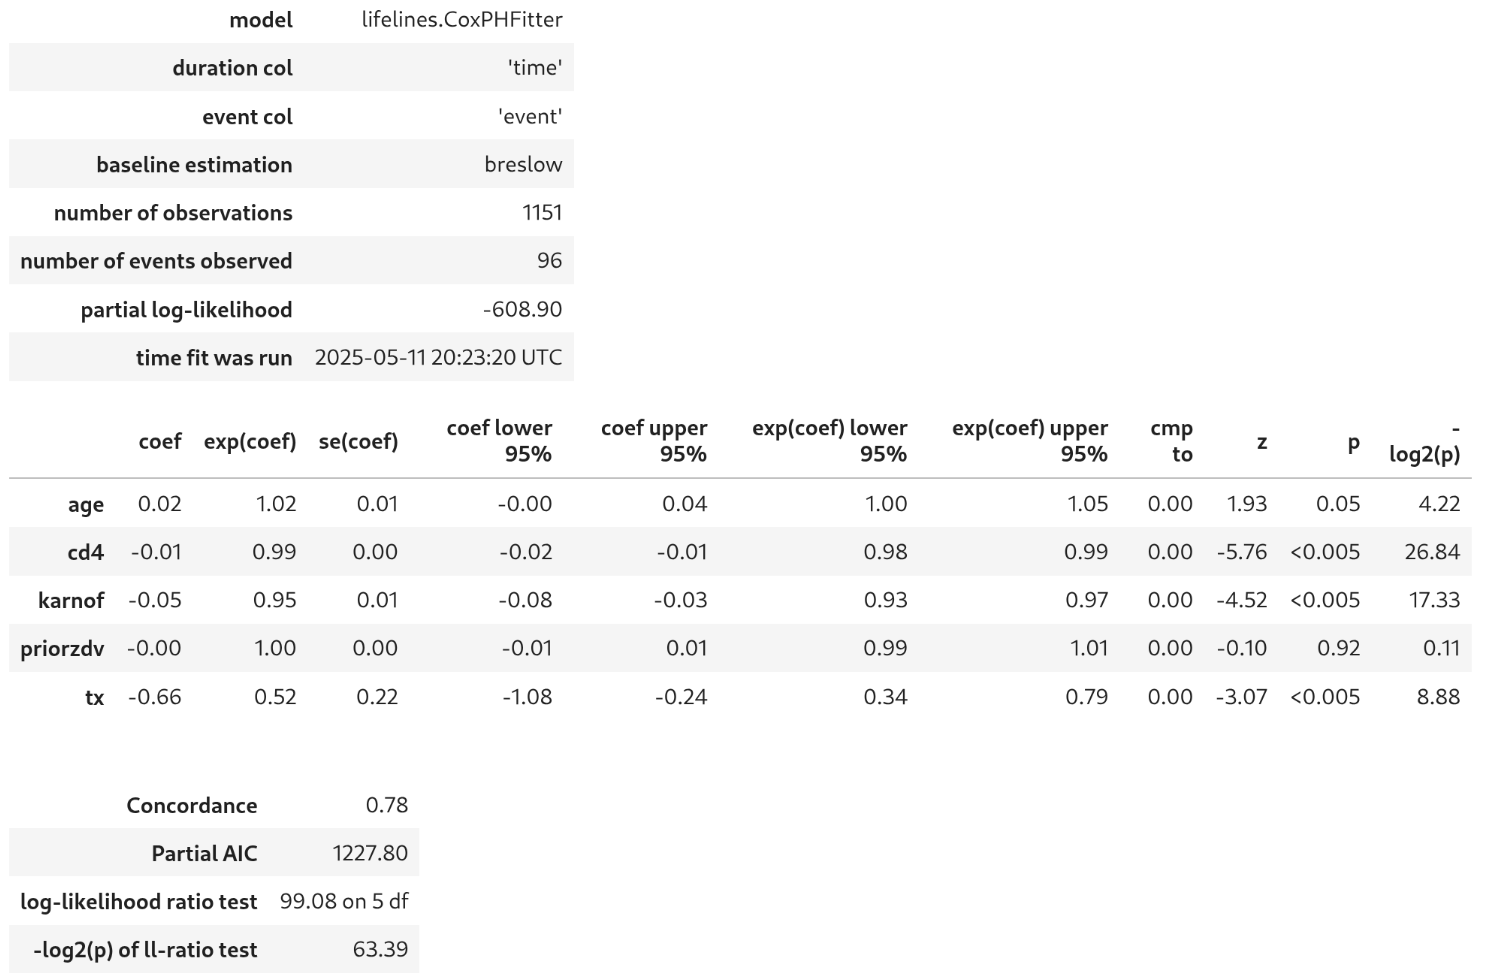

2.2 Partial Effects

Plot the partial effects of 'cd4' (CD4 count) on survival probability.

In [ ]:
# Generate sensible values for cd4
cd4_values = np.linspace(
    max(data['cd4'].quantile(0.05), 10),  # Ensures minimum of 10 cells/mm³
    data['cd4'].quantile(0.95),
    6
).astype(int)

# Create the partial effects plot
# USE cph.plot_partial_effects_on_outcome
# TODO

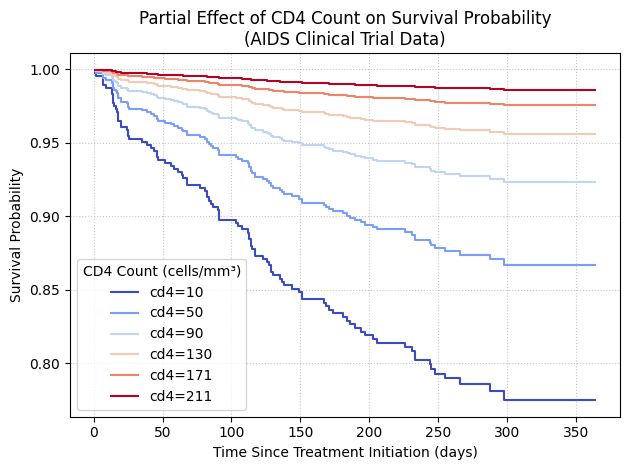

# Task 3: Random Survival Forest

3.1 RSF Model

Fit RSF Model and Predict Survival Functions

In [ ]:
# Prepare data
y = Surv.from_arrays(data['event'], data['time'])
X = data.drop(['time', 'event'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model
# USE RandomSurvivalForest
# TODO

# Select high and low CD4 count patients for comparison
X_test_high = X_test[X_test['cd4'] > X_test['cd4'].median()].sample(10, random_state=42)
X_test_low = X_test[X_test['cd4'] <= X_test['cd4'].median()].sample(10, random_state=42)
X_test_sel = pd.concat([X_test_high, X_test_low])

# Predict survival functions
# USE rsf.predict_survival_function
# TODO

# Plot results
# TODO

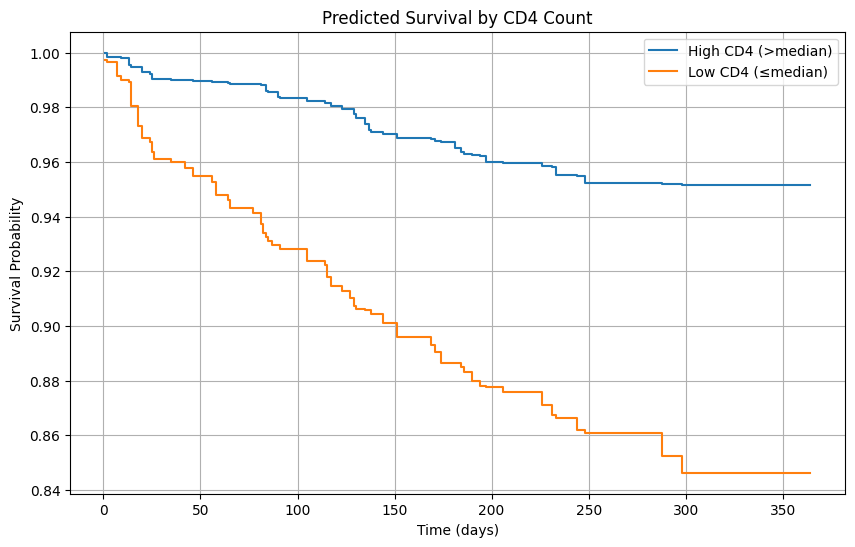

3.2 Feature Importance Analysis

In [ ]:
# USE permutation_importance
# TODO

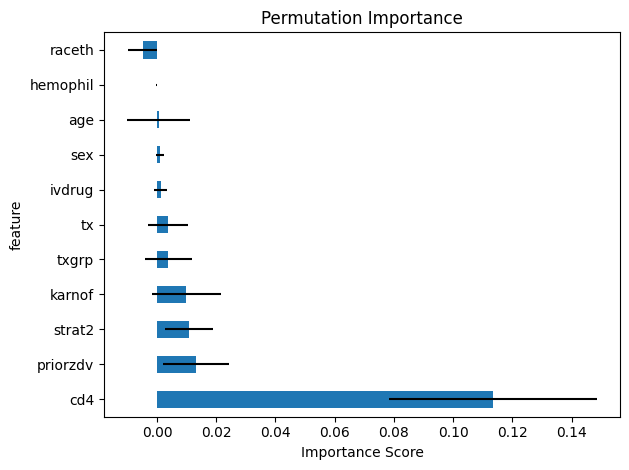

# Task 4: XGBoost AFT Model

4.1 Fit AFT Model

Fit an Accelerated Failure Time (AFT) model using XGBoost with the same covariates as the Cox model.

In [ ]:
# Prepare data for XGBoost AFT
dtrain = xgb.DMatrix(X_train[['age', 'cd4', 'karnof', 'priorzdv', 'tx']],
                     enable_categorical=True)
dtrain.set_float_info('label_lower_bound', y_train['time'])
dtrain.set_float_info('label_upper_bound', np.where(
    y_train['event'], y_train['time'], np.inf))

dtest = xgb.DMatrix(X_test[['age', 'cd4', 'karnof', 'priorzdv', 'tx']],
                    enable_categorical=True)
dtest.set_float_info('label_lower_bound', y_test['time'])
dtest.set_float_info('label_upper_bound', np.where(
    y_test['event'], y_test['time'], np.inf))

# Parameters
params = {
    # Fill parameters
    # TODO
}

# Train model
# USE xgb.train with evals=[(dtrain, 'train'), (dtest, 'test')]
# TODO

Plot feature importance from the XGBoost model.

In [ ]:
# USE xgb.plot_importance
# TODO

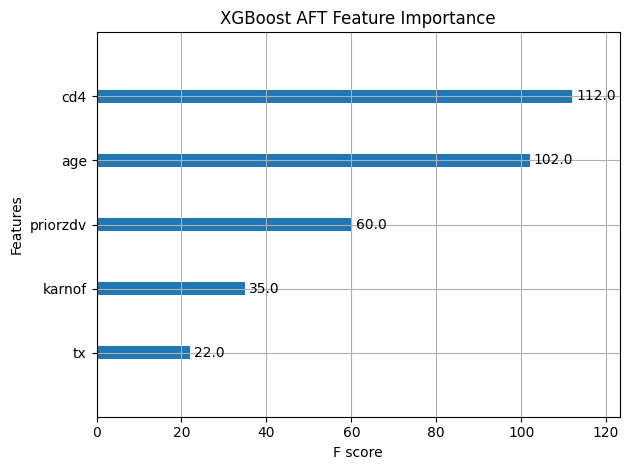

# Task 5: Model Comparison

Compare the performance of the RSF, and XGBoost AFT models using concordance index.

In [ ]:
# Be carefull, all models default outputs are different (partial_hazards, expected survival time, risk_scores)
# But we still compare performance without additional transformations of predicts
# Cause we compare not absolute values, but rankings

In [ ]:
from sksurv.metrics import concordance_index_censored

# Cox model predictions
cph_pred = cph.predict_partial_hazard(X_test)

# RSF predictions
rsf_pred = rsf.predict(X_test)

# XGBoost predictions
xgb_pred = bst.predict(dtest)

# Calculate C-index
# USE concordance_index_censored
# change sign of prediction for xgb_pred, greater time means smaller risk
# TODO

print(f"Cox PH C-index: {cph_cindex:.3f}")
print(f"RSF C-index: {rsf_cindex:.3f}")
print(f"XGBoost AFT C-index: {xgb_cindex:.3f}")

Cox PH C-index: 0.790

RSF C-index: 0.762

XGBoost AFT C-index: 0.753